In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [41]:
import os
import numpy as np
from tqdm import tqdm, tqdm_notebook

import cv2
from skimage import io
from skimage.color import rgb2gray
from skimage import exposure as ep

from skimage import feature as ft

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier


import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
img = io.imread('data/train/malignant/123_3.png')
img_gray = rgb2gray(img)
vec_hog, img_hog = ft.hog(img_gray, visualise=True)
img_lbp = ft.local_binary_pattern(img_gray, 8 * 8, 8)

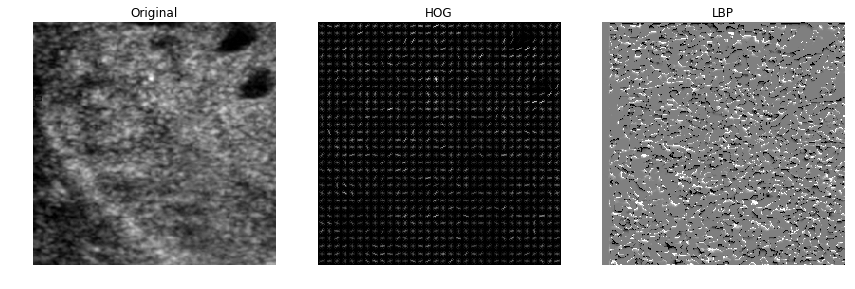

In [4]:
plt.figure(figsize = (12,6))
plt.subplot(131)
plt.axis("off")
plt.title("Original")
plt.imshow(img_gray, cmap="gray")

plt.subplot(132)
plt.axis("off")
plt.title("HOG")
plt.imshow(img_hog, cmap="gray")

plt.subplot(133)
plt.axis("off")
plt.title("LBP")
plt.imshow(img_lbp, cmap="gray")

plt.tight_layout()
plt.show()

In [5]:
img.shape

(256, 256, 3)

In [6]:
img_gray.shape

(256, 256)

In [7]:
img_hog.shape

(256, 256)

In [8]:
img_lbp.shape

(256, 256)

In [15]:
train_dir = 'data/train/'
validation_dir = 'data/validation/'
test_dir = 'data/test/'


output_classes = 2
batch_size = 32 
img_height, img_width = 256, 256

nb_train_samples = 1188
nb_validation_samples = 144
nb_test_samples = 144

In [16]:
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['benign']:
                label = 0
            elif folderName in ['malignant']:
                label = 1
#             else:
#                 label = 3
            for image_filename in tqdm_notebook(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
#                     img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [19]:
X_train, y_train = get_data(train_dir)

In [20]:
X_validation, y_validation = get_data(validation_dir)

In [21]:
X_test, y_test = get_data(test_dir)

In [22]:
from skimage import feature
import numpy as np

class LocalBinaryPatterns:
    def __init__(self, numPoints, radius):
        # store the number of points and radius
        self.numPoints = numPoints
        self.radius = radius

    def describe(self, image, eps=1e-7):
        # compute the Local Binary Pattern representation
        # of the image, and then use the LBP representation
        # to build the histogram of patterns
        lbp = feature.local_binary_pattern(image, self.numPoints,
            self.radius, method="uniform")
        (hist, _) = np.histogram(lbp.ravel(),
            bins=np.arange(0, self.numPoints + 3),
            range=(0, self.numPoints + 2))

        # normalize the histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)

        # return the histogram of Local Binary Patterns
        return hist

# settings for LBP
radius = 3
n_points = 8 * radius
desc = LocalBinaryPatterns(24, 8)

In [23]:
trainSetList = []
validationSetList = []
testSetList = []

for imgs in X_train:
    gray = cv2.cvtColor(imgs, cv2.COLOR_BGR2GRAY)
    hist = desc.describe(gray)
    trainSetList.append(hist.ravel())
    pass

for imgs in X_validation:
    gray = cv2.cvtColor(imgs, cv2.COLOR_BGR2GRAY)
    hist = desc.describe(gray)
    validationSetList.append(hist.ravel())
    pass

for imgs in X_test:
    gray = cv2.cvtColor(imgs, cv2.COLOR_BGR2GRAY)
    hist = desc.describe(gray)
    testSetList.append(hist.ravel())
    pass

trainSet = np.array(trainSetList, np.float32)
validationSet = np.array(validationSetList, np.float32)
testSet = np.array(testSetList, np.float32)

In [29]:
trainSet.shape

(1188, 26)

In [30]:
validationSet.shape

(144, 26)

In [31]:
testSet.shape

(144, 26)

In [32]:
y_train.shape

(1188,)

In [33]:
y_validation.shape

(144,)

In [34]:
y_test.shape

(144,)

In [35]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [36]:
import sklearn.svm as svm
import sklearn.neighbors as knn

KNN_lbp = knn.KNeighborsClassifier(n_neighbors=1)
KNN_lbp.fit(trainSet, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [37]:
predictions_lbp_knn = KNN_lbp.predict(testSet)

In [38]:
predictions_lbp_knn

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [39]:
print("KNN.score:",KNN_lbp.score(testSet, y_test))

KNN.score: 0.9513888888888888


In [44]:
ada_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=500)
ada_clf.fit(trainSet, y_train)
print("ada_clf.score:",ada_clf.score(testSet, y_test))

ada_clf.score: 1.0


In [46]:
gb_clf = GradientBoostingClassifier(max_depth=2, n_estimators=500)
gb_clf.fit(trainSet, y_train)
print("gb_clf.score:",gb_clf.score(testSet, y_test))

gb_clf.score: 0.9930555555555556


In [62]:
from keras.optimizers import Adam, RMSprop,SGD
adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)

model = Sequential()
model.add(Dense(1024, input_dim=trainSet.shape[1], kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, input_dim=trainSet.shape[1], kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, input_dim=trainSet.shape[1], kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))
model.compile(loss='binary_crossentropy' , optimizer=adam_opt, metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 1024)              27648     
_________________________________________________________________
dropout_19 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_20 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               131200    
_________________________________________________________________
dropout_21 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 129       
Total para

In [ ]:
history = model.fit(trainSet, y_train,epochs=1000, batch_size=5, validation_data=(testSet, y_test), verbose = 2)